In [24]:
!pip install scikit-optimize


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [25]:
import sys
sys.path.append('/kaggle/input/models/scikitlearn/default/1')

from utils import evaluate_model, prepare_data, apply_pca
import pandas as pd
from visualization import EDA_graphs, plot_model_comparison, plot_svm, plot_knn , plot_lr, plot_dt, plot_rf
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  

data_path = "/kaggle/input/dataset/Skyserver.csv"

data = pd.read_csv(data_path)

**------------------ Check And Clean Data -------------------**

In [26]:
print(data.head())

          objid          ra       dec         u         g         r         i  \
0  1.237650e+18  183.531326  0.089693  19.47406  17.04240  15.94699  15.50342   
1  1.237650e+18  183.598370  0.135285  18.66280  17.21449  16.67637  16.48922   
2  1.237650e+18  183.680207  0.126185  19.38298  18.19169  17.47428  17.08732   
3  1.237650e+18  183.870529  0.049911  17.76536  16.60272  16.16116  15.98233   
4  1.237650e+18  183.883288  0.102557  17.55025  16.26342  16.43869  16.55492   

          z  run  rerun  camcol  field     specobjid   class  redshift  plate  \
0  15.22531  752    301       4    267  3.722360e+18    STAR -0.000009   3306   
1  16.39150  752    301       4    267  3.638140e+17    STAR -0.000055    323   
2  16.80125  752    301       4    268  3.232740e+17  GALAXY  0.123111    287   
3  15.90438  752    301       4    269  3.722370e+18    STAR -0.000111   3306   
4  16.61326  752    301       4    269  3.722370e+18    STAR  0.000590   3306   

     mjd  fiberid  
0  549

**Check feature type & if there are NULL values**

In [27]:
print(data.info())  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB
None


**Print the number of unique values for each feature**

In [28]:
print(data.nunique())

objid            1
ra           10000
dec          10000
u             9730
g             9817
r             9852
i             9890
z             9896
run             23
rerun            1
camcol           6
field          703
specobjid     6349
class            3
redshift      9637
plate          487
mjd            355
fiberid        892
dtype: int64


It can be observed that rerun and objid contain only a single unique value, making them non-contributory to the dataset. 
Therefore, we remove them from the dataset

In [29]:
data = data.drop(columns=['objid', 'rerun'])

**Check if there are duplicated values**

In [30]:
print(data.duplicated().sum()) 

0


**Features Statistics**

In [31]:
print(data.describe()) 

                 ra           dec             u             g             r  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean     175.529987     14.836148     18.619355     17.371931     16.840963   
std       47.783439     25.212207      0.828656      0.945457      1.067764   
min        8.235100     -5.382632     12.988970     12.799550     12.431600   
25%      157.370946     -0.539035     18.178035     16.815100     16.173333   
50%      180.394514      0.404166     18.853095     17.495135     16.858770   
75%      201.547279     35.649397     19.259232     18.010145     17.512675   
max      260.884382     68.542265     19.599900     19.918970     24.802040   

                  i             z           run        camcol         field  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      16.583579     16.422833    981.034800      3.648700    302.380100   
std        1.141805      1.203188    273.305024    

**Histogram - Plots the distribution of a numeric variable:**

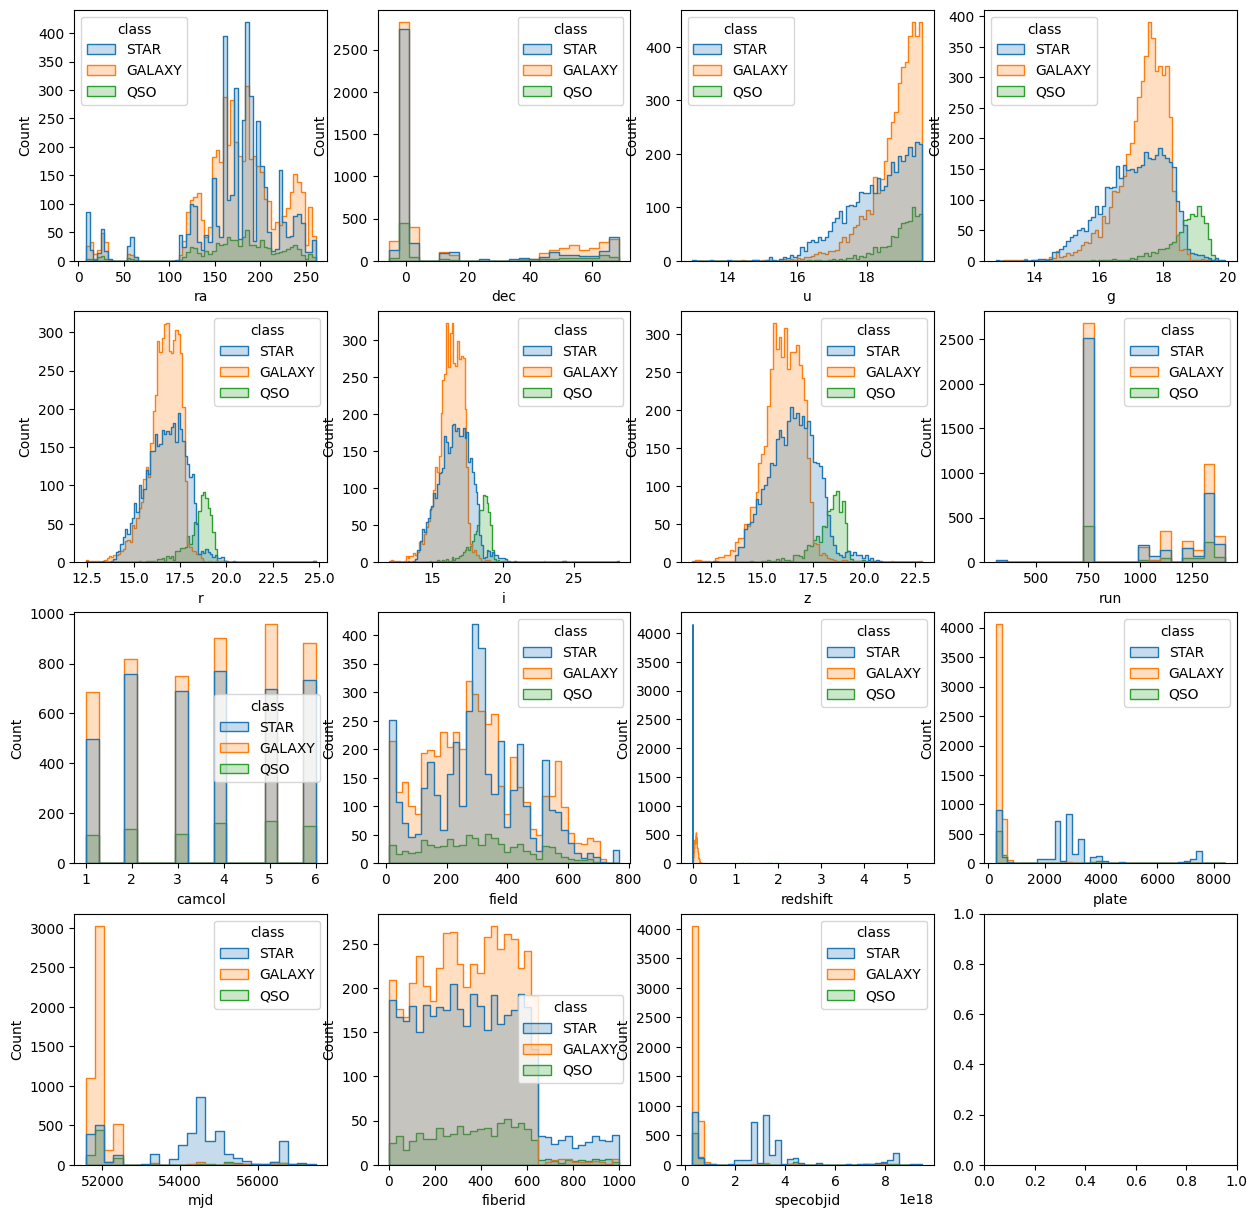

In [32]:
col=[ 'ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'run','camcol','field','redshift', 'plate', 'mjd', 'fiberid', "specobjid"]
plt.subplots(4,4,figsize=(15,15)) 
for i in range(len(col)):  
    plt.subplot(4,4,i+1)
    sns.histplot(data,x=col[i],hue="class",element="step")
    plt.xlabel(col[i])
plt.show()

**Density Plot - Plots the density distribution of a continuous variable:**

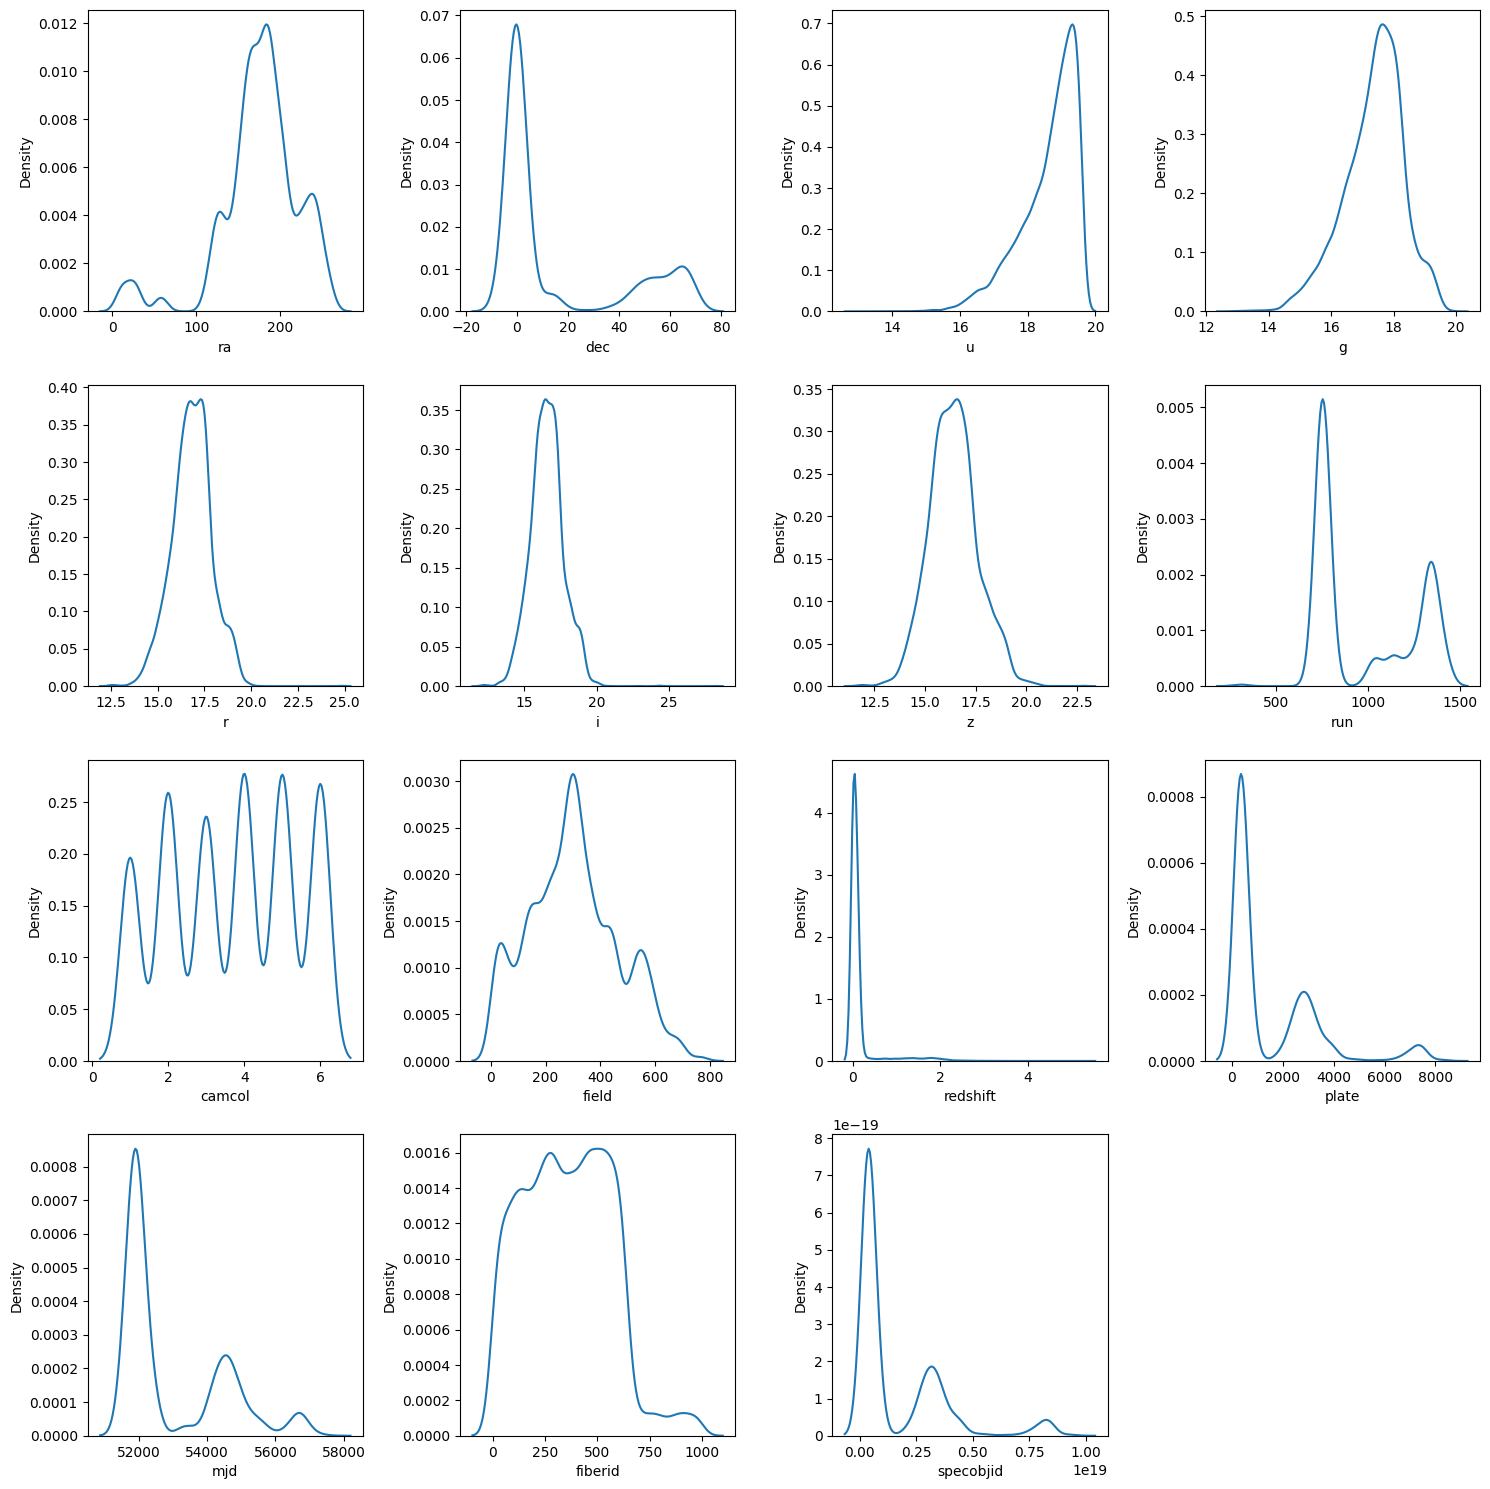

In [33]:
plt.figure(figsize=(15, 15))  
for i in range(len(col)):
    plt.subplot(4, 4, i+1)
    sns.kdeplot(data=data, x=col[i])  
plt.tight_layout()
plt.show()

Most numerical variables (u, g, r, i, z) exhibit a normal-like distribution, indicating that their values are centered around a mean. This is particularly useful when preprocessing, as features with normal distributions can benefit more from standardization or scaling. The other variables, like plate, fiberid, and mjd, show relatively uniform distributions, suggesting that these features might not have as much predictive power on their own

**Box plots - The data shows varying levels of dispersion across features:**

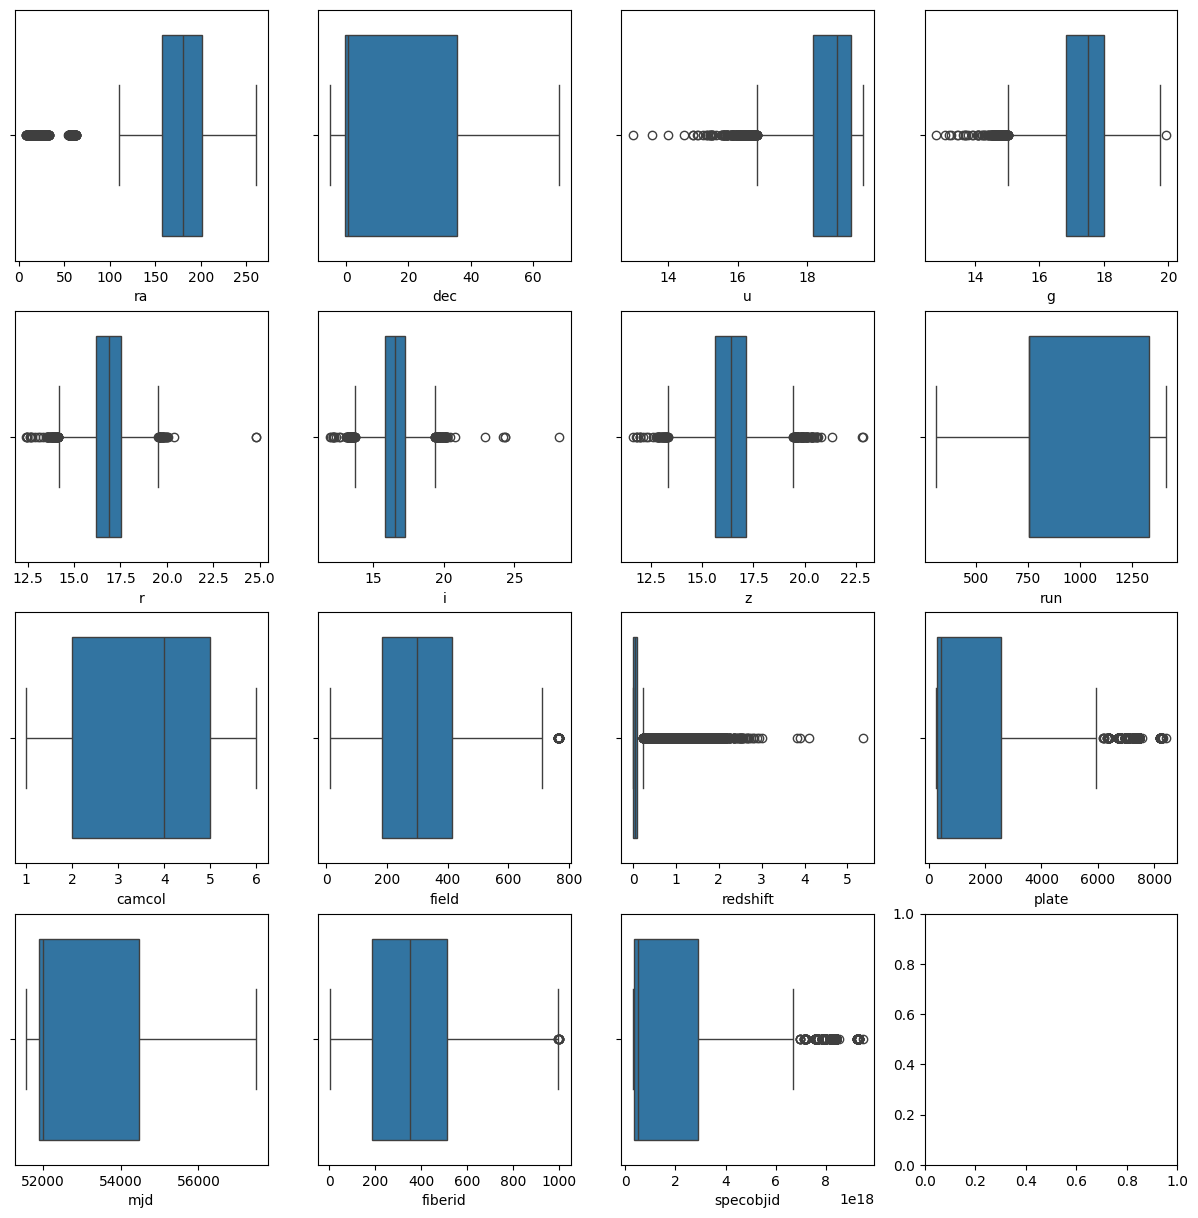

In [34]:
plt.subplots(4,4,figsize=(15,15)) 
for i in  range(len(col)):  
    plt.subplot(4,4,i+1)
    sns.boxplot(data,x=col[i])
    plt.xlabel(col[i])
plt.show()

With some (like u, g, r, i, z) having relatively low dispersion, while others (such as m, dec, run, field, plate, mjd, fiberid) exhibit higher dispersion. Certain features, like redshift and specobjid, contain many outliers, which should be carefully examined and handled

**Heatmap - represents a correlation matrix between various variables:**

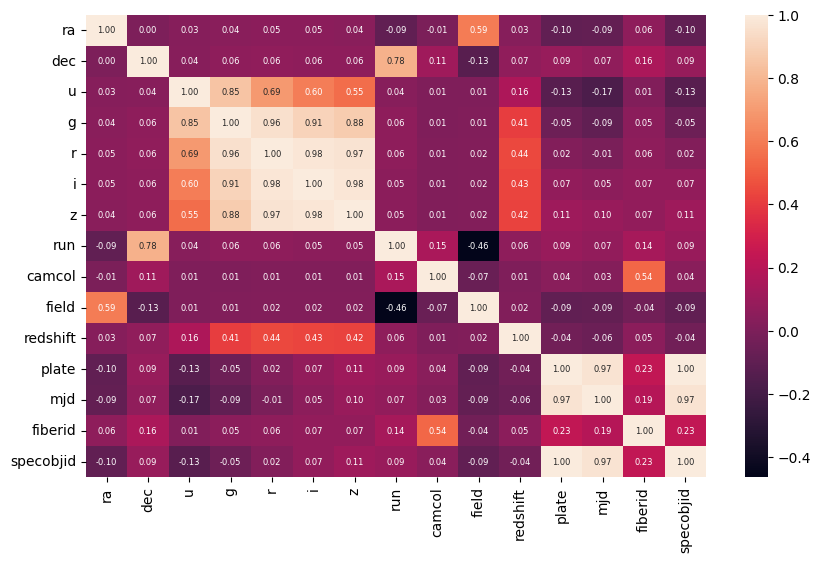

In [35]:
plt.figure(figsize=(10, 6))  
sns.heatmap(data[col].corr(), annot=True, annot_kws={'size':6}, fmt='.2f')  
plt.show()

Represents a correlation matrix between various variables. Correlation measures the strength and direction of the linear relationship between two variables. 

The strong positive correlations among u, g, r, i, and z suggest that these variables might carry redundant information, and so does specobjid, mjd and plate. This is a common scenario in astronomy, where these bands represent measurements of the same object under different wavelengths. Techniques like PCA or feature selection could reduce dimensionality while retaining the most relevant information.
Specobjid and plate have perfect correlation (1.0) it suggests that one is a deterministic function of the other, meaning that knowing the value of one fully determines the value of the other. 
This redundancy indicates that both features encode the same underlying information, so we can removed one of them.

In [36]:
data = data.drop(columns=['specobjid'])

**Scatter Plots - Used to compare pairs of features (u, g, r, i, z):**

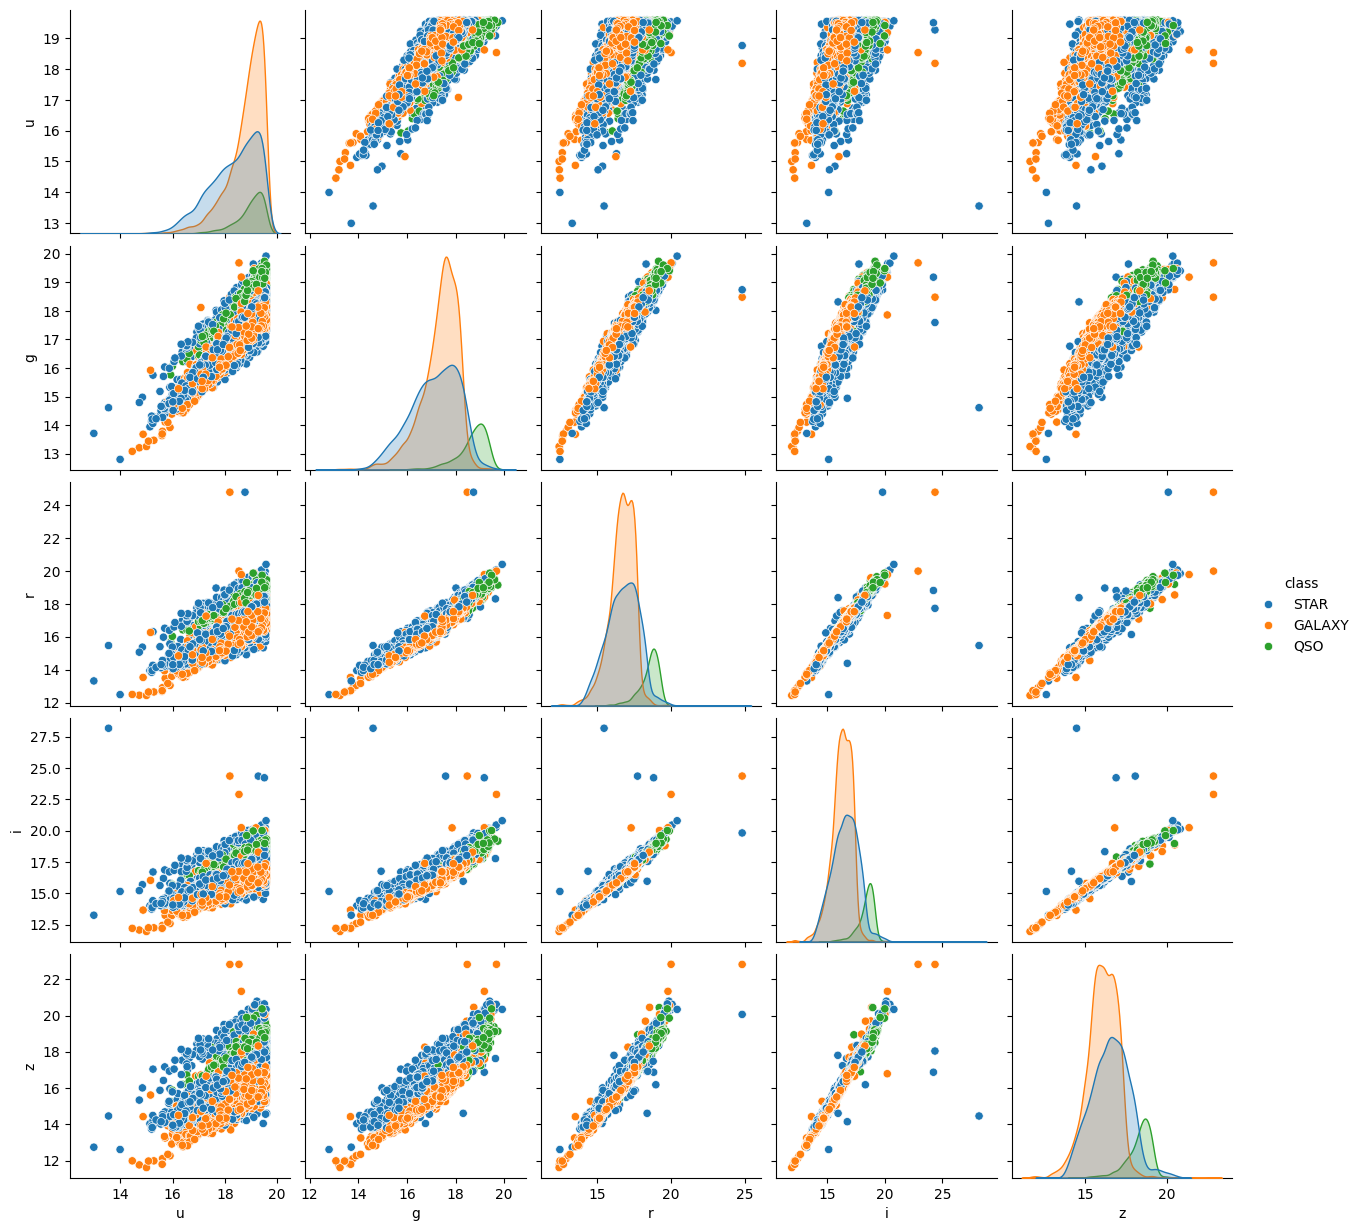

In [37]:
sns.pairplot(data=data[['u', 'g', 'r', 'i', 'z','class']],hue='class')
plt.show()

Despite the correlations, the significant overlap between the STAR, GALAXY, and QSO classes suggests that these features alone may not provide enough information to distinguish between these classes clearly. 
Dimensionality reduction methods like PCA could simplify the model without significant performance loss

**Bar Plot of Class Distribution:**

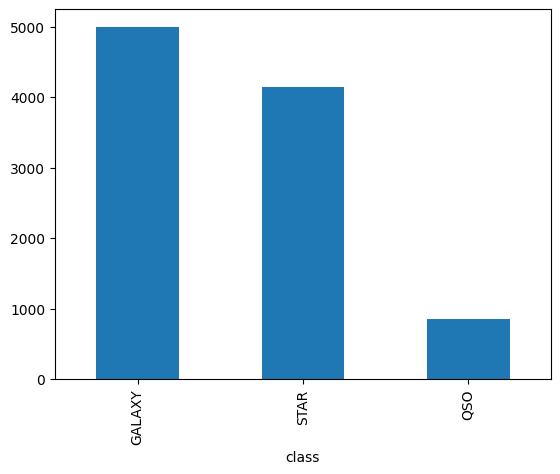

In [38]:
data['class'].value_counts().plot(kind='bar')  
plt.show()

The dataset demonstrates a significant imbalance between the classes. Specifically, we have nearly 5,000 samples for the Galaxy class, slightly over 4,000 samples for the Star class, and fewer than 1,000 samples for the QSO class.We will first attempt to classify the data using the original distribution as is. If the classification results for the QSO class are unsatisfactory, we will consider applying one of the following techniques to address the class imbalance: Oversampling, Data Augmentation or Weighted Loss Function. 

**-------------------- Prepare Data & Split Data --------------------**

In [39]:
x_train, x_test, y_train, y_test, x_val, y_val, classes, feature_names = prepare_data(data)

**-------------------- Define Models --------------------**

In [40]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

def svm(x_train, y_train, x_val, x_test):

    svm_model = SVC(gamma='scale', random_state=42)

    param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

    grid_search = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_

    print("Best model:", best_model)

    y_pred_train = best_model.predict(x_train)
    y_pred_val = best_model.predict(x_val)
    y_pred_test = best_model.predict(x_test)

    return best_model, y_pred_train, y_pred_val, y_pred_test

In [41]:
from sklearn.neighbors import KNeighborsClassifier

def knn(x_train, y_train, x_val, x_test, min_neighbors=3):

    knn_model = KNeighborsClassifier(weights = 'uniform')

    param_grid = {
        'n_neighbors': range(min_neighbors, 15, 2),  
        'p': [1, 2, 3]  
    }

    grid_search = GridSearchCV(knn_model, param_grid, cv=5)
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_

    print("Best model:", best_model)

    y_pred_train = best_model.predict(x_train)
    y_pred_val = best_model.predict(x_val)
    y_pred_test = best_model.predict(x_test)

    return best_model, y_pred_train, y_pred_val, y_pred_test

In [42]:
from sklearn.linear_model import LogisticRegression

def logistic_regression(x_train, y_train, x_val, x_test):

    lr_model = LogisticRegression(max_iter=10000, solver='liblinear')    

    param_grid = {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}

    grid_search = GridSearchCV(lr_model, param_grid, cv=5)
    grid_search.fit(x_train, y_train)

    best_model = grid_search.best_estimator_

    print("Best model:", best_model)

    y_pred_train = best_model.predict(x_train)
    y_pred_val = best_model.predict(x_val)
    y_pred_test = best_model.predict(x_test)

    return best_model, y_pred_train, y_pred_val, y_pred_test

In [43]:
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV

def decision_tree(x_train, y_train, x_val, x_test):
    
    dt_model = DecisionTreeClassifier()
    
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'max_depth': (2, 21),
        'min_samples_split': (2, 20), 
        'min_samples_leaf': (2, 20)
    }

    bayes_search = BayesSearchCV(dt_model, param_grid, cv=5)
    bayes_search.fit(x_train, y_train)

    best_model = bayes_search.best_estimator_

    print("Best model:", best_model)

    y_pred_train = best_model.predict(x_train)
    y_pred_val = best_model.predict(x_val)
    y_pred_test = best_model.predict(x_test)

    return best_model, y_pred_train, y_pred_val, y_pred_test

In [44]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(x_train, y_train, x_val, x_test):
    
    rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

    param_space = {
        'n_estimators': (10, 200),  
        'max_depth': (2, 20),  
        'min_samples_split': (2, 20), 
        'min_samples_leaf': (1, 20)
    }

    bayes_search = BayesSearchCV(
        rf_model,
        param_space,
        n_iter=30,  
        random_state=42,
        cv = 5
    )
    
    bayes_search.fit(x_train, y_train)

    best_model = bayes_search.best_estimator_
    print("Best model:", best_model)

    y_pred_train = best_model.predict(x_train)
    y_pred_val = best_model.predict(x_val)
    y_pred_test = best_model.predict(x_test)

    return best_model, y_pred_train, y_pred_val, y_pred_test

In [45]:
models = {
    "SVM": (svm, plot_svm),
    "KNN": (knn, plot_knn),
    "Logistic Regression": (logistic_regression, plot_lr),
    "Decision Tree": (decision_tree, plot_dt),
    "Random Forest": (random_forest, plot_rf)
}

results = {"Without PCA": {}, "With PCA": {}}


===== Running SVM =====
Best model: SVC(C=10, kernel='linear', random_state=42)
Train Result:
Accuracy: 0.988125

Classification Report:
               precision    recall  f1-score   support

        STAR       0.98      1.00      0.99      2667
      GALAXY       0.99      0.98      0.99      3181
         QSO       0.98      0.97      0.97       552

    accuracy                           0.99      6400
   macro avg       0.99      0.98      0.98      6400
weighted avg       0.99      0.99      0.99      6400


Confusion Matrix
 [[2667    0    0]
 [  47 3123   11]
 [   1   17  534]]
Validation Result:
Accuracy: 0.99

Classification Report:
               precision    recall  f1-score   support

        STAR       0.99      1.00      0.99       655
      GALAXY       0.99      0.99      0.99       817
         QSO       0.98      0.95      0.96       128

    accuracy                           0.99      1600
   macro avg       0.99      0.98      0.98      1600
weighted avg       0.

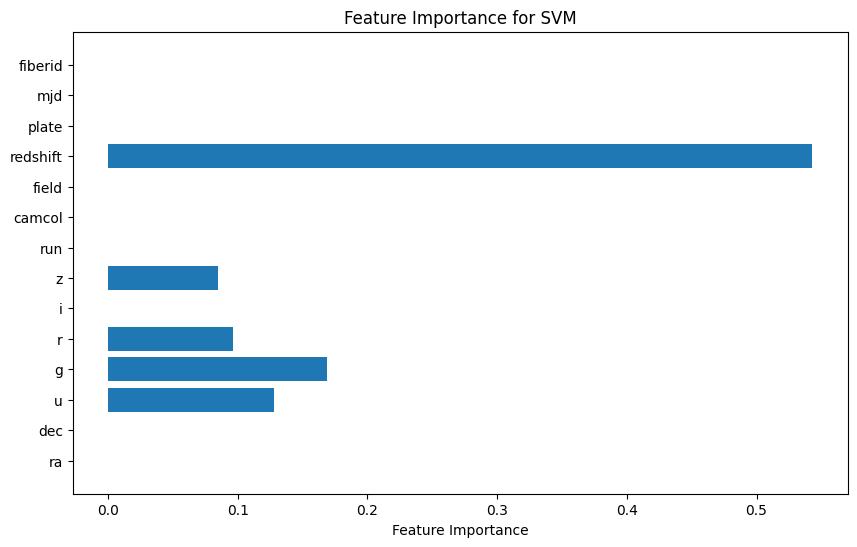

In [46]:
print("\n===== Running SVM =====")
model_name = "SVM"
model_func, plot_func = models[model_name]
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train, y_train, x_val, x_test)
print("Train Result:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train, y_train, model, feature_names)
results["Without PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))


===== Running KNN =====
Best model: KNeighborsClassifier(n_neighbors=3, p=1)
Train Result:
Accuracy: 0.9525

Classification Report:
               precision    recall  f1-score   support

        STAR       0.96      0.94      0.95      2667
      GALAXY       0.94      0.97      0.96      3181
         QSO       0.98      0.90      0.94       552

    accuracy                           0.95      6400
   macro avg       0.96      0.94      0.95      6400
weighted avg       0.95      0.95      0.95      6400


Confusion Matrix
 [[2517  148    2]
 [  91 3084    6]
 [  23   34  495]]
Validation Result:
Accuracy: 0.91

Classification Report:
               precision    recall  f1-score   support

        STAR       0.92      0.88      0.90       655
      GALAXY       0.89      0.95      0.92       817
         QSO       0.96      0.82      0.89       128

    accuracy                           0.91      1600
   macro avg       0.93      0.88      0.90      1600
weighted avg       0.91   

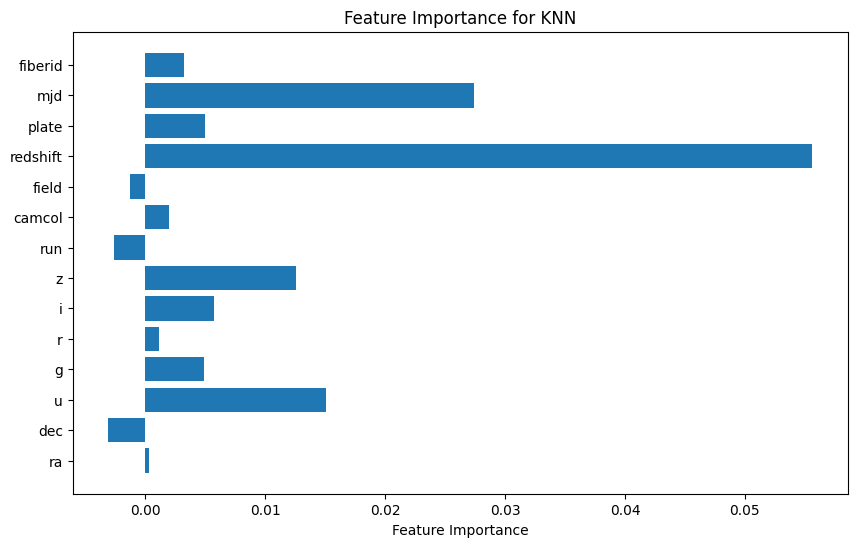

In [47]:
print("\n===== Running KNN =====")
model_name = "KNN"
model_func, plot_func = models[model_name]
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train, y_train, x_val, x_test)
print("Train Result:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train, y_train, model, feature_names)
results["Without PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))

The KNN results show slight overfitting, so we chose a large k to make the model less sensitive to noise.


===== Running KNN (min neighbors - 7) =====
Best model: KNeighborsClassifier(n_neighbors=7, p=1)
Train Result:
Accuracy: 0.929375

Classification Report:
               precision    recall  f1-score   support

        STAR       0.94      0.91      0.92      2667
      GALAXY       0.91      0.96      0.94      3181
         QSO       0.98      0.85      0.91       552

    accuracy                           0.93      6400
   macro avg       0.95      0.91      0.92      6400
weighted avg       0.93      0.93      0.93      6400


Confusion Matrix
 [[2416  249    2]
 [ 110 3065    6]
 [  33   52  467]]
Validation Result:
Accuracy: 0.900625

Classification Report:
               precision    recall  f1-score   support

        STAR       0.92      0.86      0.89       655
      GALAXY       0.87      0.95      0.91       817
         QSO       0.98      0.80      0.88       128

    accuracy                           0.90      1600
   macro avg       0.93      0.87      0.89      1600


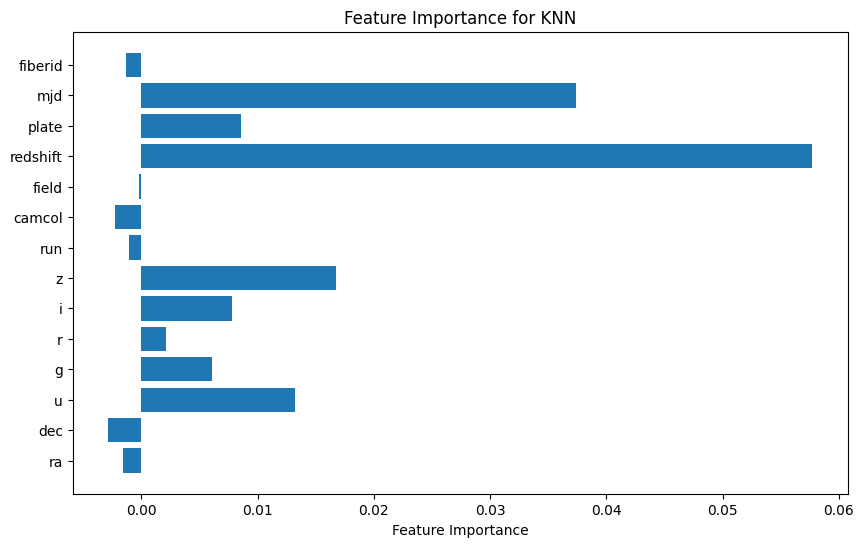

In [48]:
print("\n===== Running KNN (min neighbors - 7) =====")
model_name = "KNN"
model_func, plot_func = models[model_name]
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train, y_train, x_val, x_test, min_neighbors=7)
print("Train Result:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train, y_train, model, feature_names)
results["Without PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))


===== Running Logistic Regression =====
Best model: LogisticRegression(C=100, max_iter=10000, penalty='l1', solver='liblinear')
Train Result:
Accuracy: 0.98453125

Classification Report:
               precision    recall  f1-score   support

        STAR       0.99      1.00      0.99      2667
      GALAXY       0.98      0.99      0.98      3181
         QSO       0.97      0.92      0.95       552

    accuracy                           0.98      6400
   macro avg       0.98      0.97      0.97      6400
weighted avg       0.98      0.98      0.98      6400


Confusion Matrix
 [[2655   12    0]
 [  29 3137   15]
 [   1   42  509]]
Validation Result:
Accuracy: 0.984375

Classification Report:
               precision    recall  f1-score   support

        STAR       0.99      0.99      0.99       655
      GALAXY       0.98      0.99      0.98       817
         QSO       0.97      0.91      0.94       128

    accuracy                           0.98      1600
   macro avg       0.

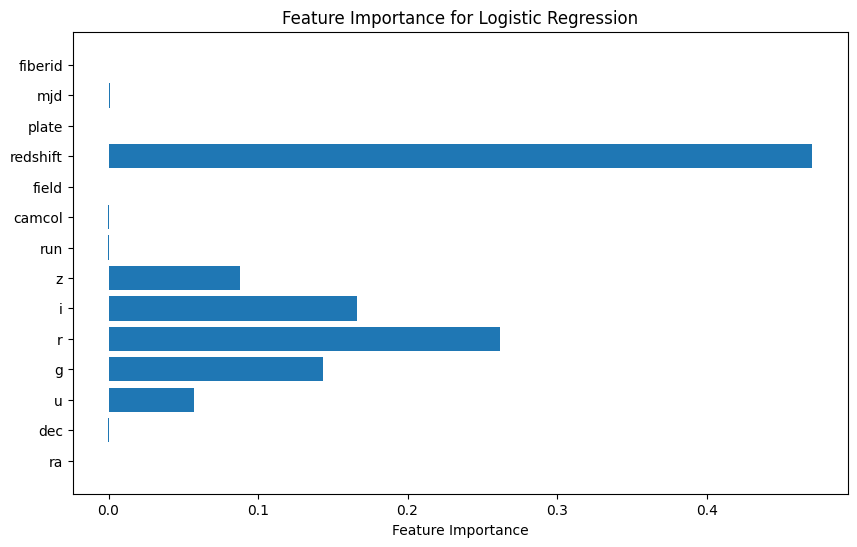

In [49]:
print("\n===== Running Logistic Regression =====")
model_name = "Logistic Regression"
model_func, plot_func = models[model_name]
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train, y_train, x_val, x_test)
print("Train Result:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train, y_train, model, feature_names)
results["Without PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))


===== Running Decision Tree =====
Best model: DecisionTreeClassifier(criterion='entropy', max_depth=4, min_samples_leaf=6,
                       min_samples_split=19)
Train Result:
Accuracy: 0.99125

Classification Report:
               precision    recall  f1-score   support

        STAR       1.00      1.00      1.00      2667
      GALAXY       0.99      1.00      0.99      3181
         QSO       0.98      0.93      0.95       552

    accuracy                           0.99      6400
   macro avg       0.99      0.97      0.98      6400
weighted avg       0.99      0.99      0.99      6400


Confusion Matrix
 [[2664    3    0]
 [   3 3168   10]
 [   1   39  512]]
Validation Result:
Accuracy: 0.99125

Classification Report:
               precision    recall  f1-score   support

        STAR       1.00      1.00      1.00       655
      GALAXY       0.99      1.00      0.99       817
         QSO       0.97      0.91      0.94       128

    accuracy                           

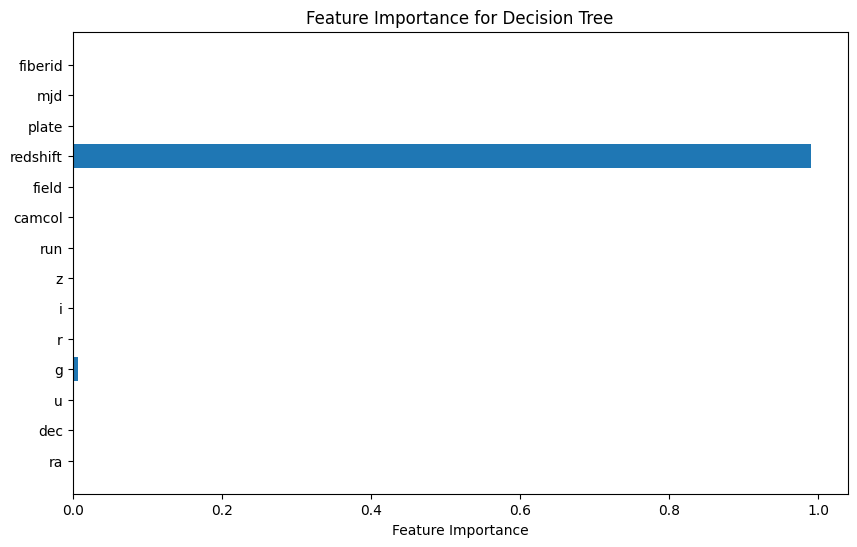

In [50]:
print("\n===== Running Decision Tree =====")
model_name = "Decision Tree"
model_func, plot_func = models[model_name]
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train, y_train, x_val, x_test)
print("Train Result:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train, y_train, model, feature_names)
results["Without PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))


===== Running Random Forest =====
Best model: RandomForestClassifier(max_depth=14, n_estimators=200, n_jobs=-1,
                       random_state=42)
Train Result:
Accuracy: 0.99890625

Classification Report:
               precision    recall  f1-score   support

        STAR       1.00      1.00      1.00      2667
      GALAXY       1.00      1.00      1.00      3181
         QSO       1.00      0.99      0.99       552

    accuracy                           1.00      6400
   macro avg       1.00      1.00      1.00      6400
weighted avg       1.00      1.00      1.00      6400


Confusion Matrix
 [[2667    0    0]
 [   0 3181    0]
 [   0    7  545]]
Validation Result:
Accuracy: 0.99

Classification Report:
               precision    recall  f1-score   support

        STAR       1.00      1.00      1.00       655
      GALAXY       0.99      0.99      0.99       817
         QSO       0.98      0.92      0.95       128

    accuracy                           0.99      1600
 

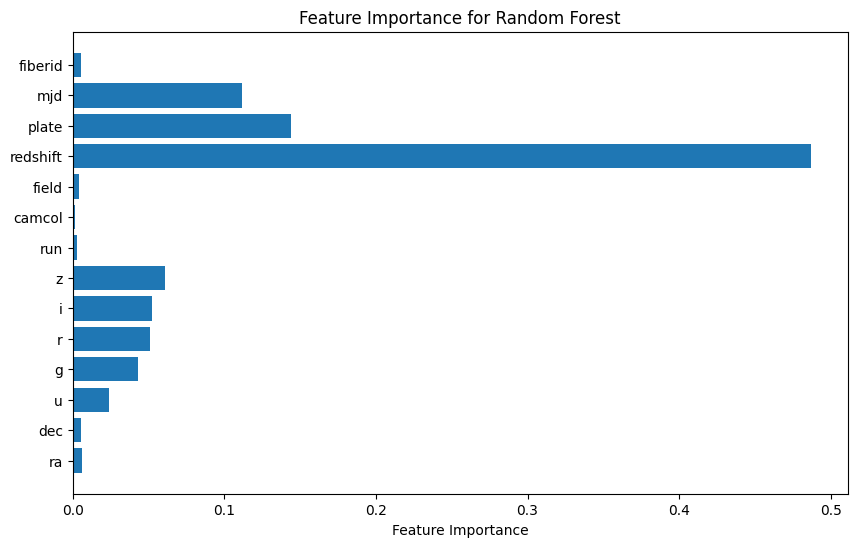

In [51]:
print("\n===== Running Random Forest =====")
model_name = "Random Forest"
model_func, plot_func = models[model_name]
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train, y_train, x_val, x_test)
print("Train Result:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train, y_train, model, feature_names)
results["Without PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))

**-------------------- Apply PCA --------------------**

In [52]:
x_train_pca, x_val_pca, x_test_pca = apply_pca(x_train, x_val, x_test, dim=9) # Reduce to 9 dimenation
feature_names = ['vec1', 'vec2', 'vec3', 'vec4', 'vec5', 'vec6', 'vec7', 'vec8', 'vec9']

Explained Variance Ratio: [0.33126534 0.17065569 0.13078673 0.11149466 0.08777563 0.06289544
 0.03226195 0.03099111 0.0287583 ]
Final Variance Ratio: 0.9868848577351299



===== Running SVM With PCA =====
Best model: SVC(C=10, kernel='linear', random_state=42)
Train Result With PCA:
Accuracy: 0.9834375

Classification Report:
               precision    recall  f1-score   support

        STAR       0.98      1.00      0.99      2667
      GALAXY       0.99      0.98      0.98      3181
         QSO       0.97      0.93      0.95       552

    accuracy                           0.98      6400
   macro avg       0.98      0.97      0.98      6400
weighted avg       0.98      0.98      0.98      6400


Confusion Matrix
 [[2659    8    0]
 [  47 3120   14]
 [   1   36  515]]
Validation Result With PCA:
Accuracy: 0.985625

Classification Report:
               precision    recall  f1-score   support

        STAR       0.99      1.00      0.99       655
      GALAXY       0.99      0.99      0.99       817
         QSO       0.98      0.92      0.95       128

    accuracy                           0.99      1600
   macro avg       0.98      0.97      0.98

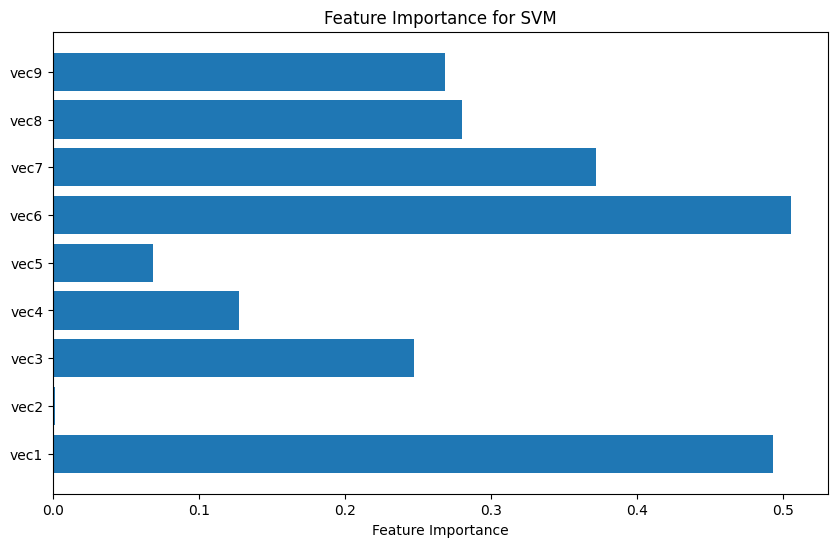

In [54]:
print("\n===== Running SVM With PCA =====")
model_name = "SVM"
model_func, plot_func = models[model_name]
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train_pca, y_train, x_val_pca, x_test_pca)
print("Train Result With PCA:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result With PCA:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result With PCA:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train_pca, y_train, model, feature_names)
results["With PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))


===== Running KNN With PCA =====
Best model: KNeighborsClassifier(n_neighbors=3)
Train Result With PCA:
Accuracy: 0.943125

Classification Report:
               precision    recall  f1-score   support

        STAR       0.95      0.93      0.94      2667
      GALAXY       0.93      0.96      0.95      3181
         QSO       0.99      0.90      0.94       552

    accuracy                           0.94      6400
   macro avg       0.96      0.93      0.94      6400
weighted avg       0.94      0.94      0.94      6400


Confusion Matrix
 [[2479  187    1]
 [ 115 3061    5]
 [  27   29  496]]
Validation Result With PCA:
Accuracy: 0.8925

Classification Report:
               precision    recall  f1-score   support

        STAR       0.90      0.85      0.87       655
      GALAXY       0.87      0.93      0.90       817
         QSO       0.97      0.86      0.91       128

    accuracy                           0.89      1600
   macro avg       0.92      0.88      0.90      1600


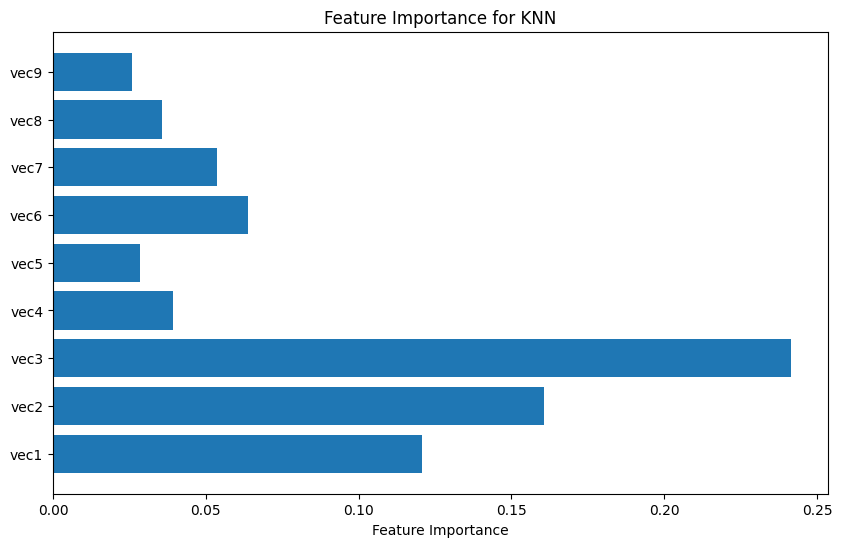

In [55]:
print("\n===== Running KNN With PCA =====")
model_name = "KNN"
model_func, plot_func = models[model_name]
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train_pca, y_train, x_val_pca, x_test_pca)
print("Train Result With PCA:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result With PCA:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result With PCA:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train_pca, y_train, model, feature_names)
results["With PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))


===== Running Logistic Regression With PCA =====
Best model: LogisticRegression(C=100, max_iter=10000, penalty='l1', solver='liblinear')
Train Result With PCA:
Accuracy: 0.9809375

Classification Report:
               precision    recall  f1-score   support

        STAR       0.98      0.99      0.99      2667
      GALAXY       0.98      0.98      0.98      3181
         QSO       0.96      0.93      0.95       552

    accuracy                           0.98      6400
   macro avg       0.98      0.97      0.97      6400
weighted avg       0.98      0.98      0.98      6400


Confusion Matrix
 [[2650   17    0]
 [  47 3113   21]
 [   1   36  515]]
Validation Result With PCA:
Accuracy: 0.981875

Classification Report:
               precision    recall  f1-score   support

        STAR       0.99      0.99      0.99       655
      GALAXY       0.98      0.99      0.98       817
         QSO       0.94      0.91      0.92       128

    accuracy                           0.98      

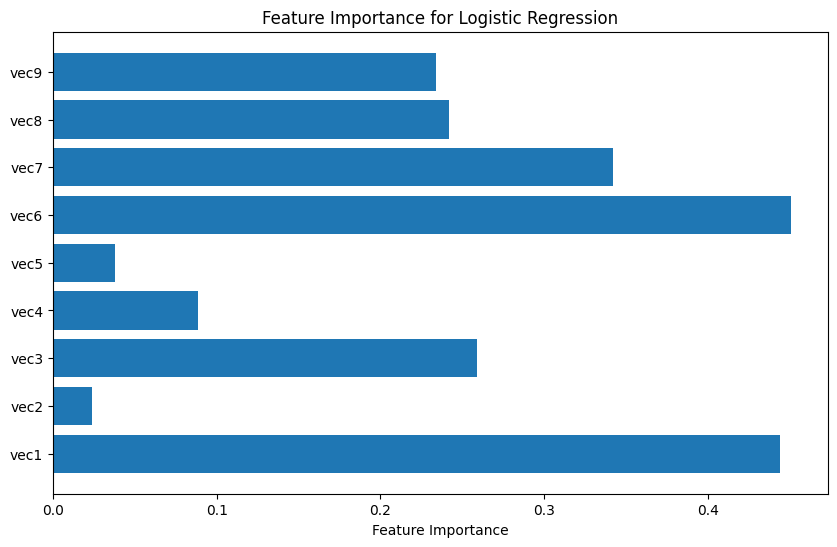

In [56]:
print("\n===== Running Logistic Regression With PCA =====")
model_name = "Logistic Regression"
model_func, plot_func = models[model_name]
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train_pca, y_train, x_val_pca, x_test_pca)
print("Train Result With PCA:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result With PCA:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result With PCA:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train_pca, y_train, model, feature_names)
results["With PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))


===== Running Decision Tree With PCA =====
Best model: DecisionTreeClassifier(max_depth=9, min_samples_leaf=2)
Train Result With PCA:
Accuracy: 0.93078125

Classification Report:
               precision    recall  f1-score   support

        STAR       0.93      0.91      0.92      2667
      GALAXY       0.92      0.96      0.94      3181
         QSO       0.99      0.86      0.92       552

    accuracy                           0.93      6400
   macro avg       0.95      0.91      0.93      6400
weighted avg       0.93      0.93      0.93      6400


Confusion Matrix
 [[2438  227    2]
 [ 137 3043    1]
 [  35   41  476]]
Validation Result With PCA:
Accuracy: 0.8875

Classification Report:
               precision    recall  f1-score   support

        STAR       0.89      0.86      0.87       655
      GALAXY       0.87      0.93      0.90       817
         QSO       0.98      0.80      0.88       128

    accuracy                           0.89      1600
   macro avg       0.9

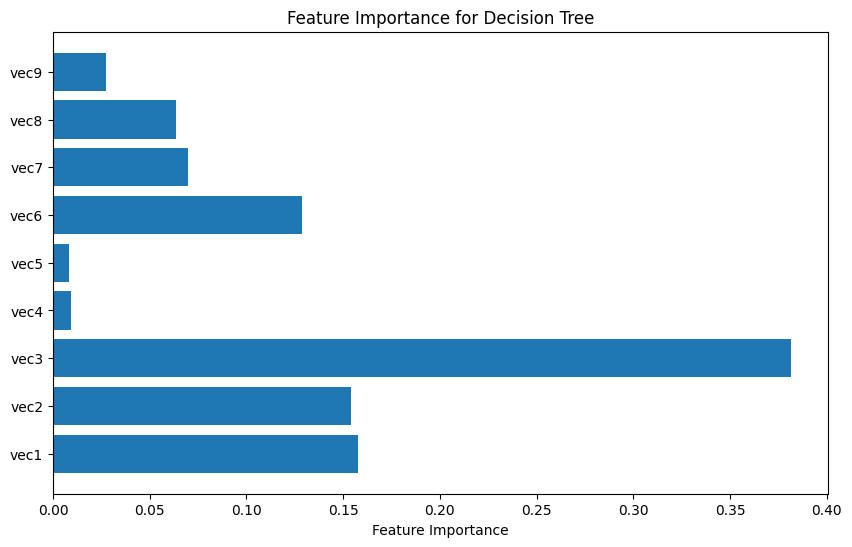

In [57]:
print("\n===== Running Decision Tree With PCA =====")
model_name = "Decision Tree"
model_func, plot_func = models[model_name]
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train_pca, y_train, x_val_pca, x_test_pca)
print("Train Result With PCA:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result With PCA:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result With PCA:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train_pca, y_train, model, feature_names)
results["With PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))


===== Running Random Forest With PCA =====
Best model: RandomForestClassifier(max_depth=19, min_samples_split=3, n_estimators=196,
                       n_jobs=-1, random_state=42)
Train Result With PCA:
Accuracy: 0.99640625

Classification Report:
               precision    recall  f1-score   support

        STAR       1.00      0.99      1.00      2667
      GALAXY       0.99      1.00      1.00      3181
         QSO       1.00      0.99      0.99       552

    accuracy                           1.00      6400
   macro avg       1.00      0.99      1.00      6400
weighted avg       1.00      1.00      1.00      6400


Confusion Matrix
 [[2651   16    0]
 [   0 3181    0]
 [   0    7  545]]
Validation Result With PCA:
Accuracy: 0.918125

Classification Report:
               precision    recall  f1-score   support

        STAR       0.92      0.90      0.91       655
      GALAXY       0.91      0.94      0.93       817
         QSO       0.97      0.88      0.92       128

   

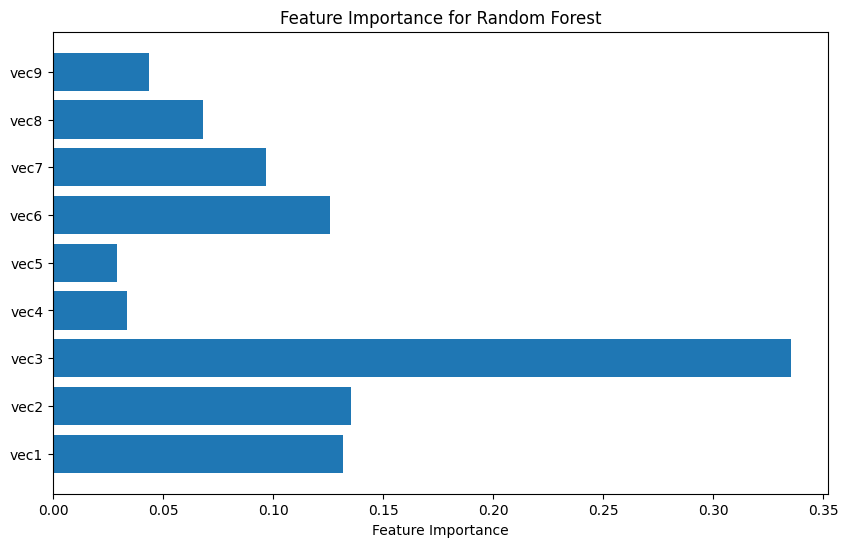

In [58]:
print("\n===== Running Random Forest With PCA =====")
model_name = "Random Forest"
model_func, plot_func = models[model_name]
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train_pca, y_train, x_val_pca, x_test_pca)
print("Train Result With PCA:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result With PCA:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result With PCA:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train_pca, y_train, model, feature_names)
results["With PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))

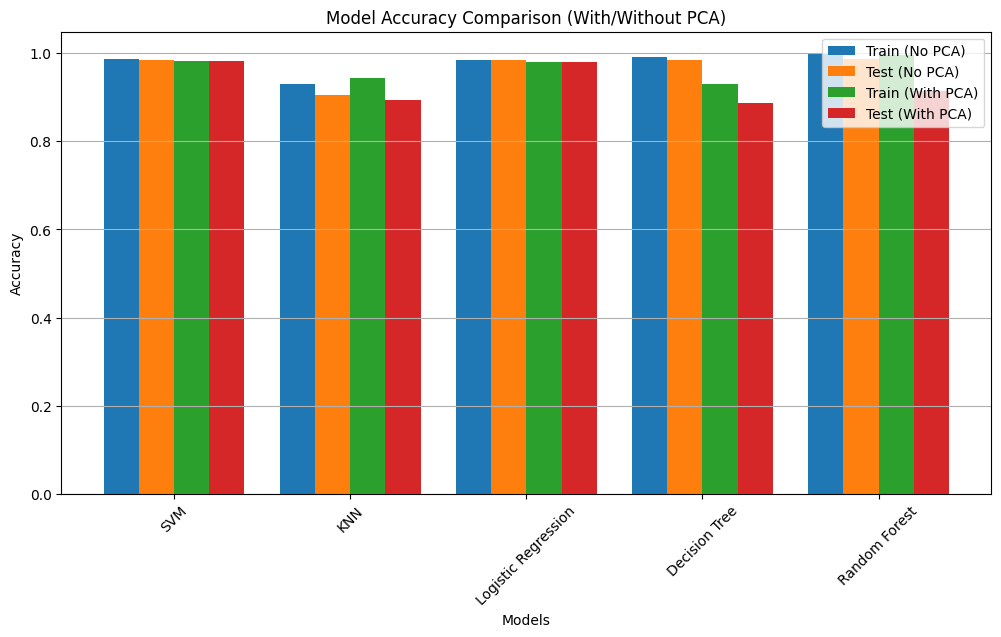

In [59]:
plot_model_comparison(results, models)

**---------------------- Delete Less Important Features (According to the results from above) ----------------------**

Features to remove: fiberid, camcol, field, run, ra, plate, mjd, dec

In [62]:
data = pd.read_csv(data_path)
data = data.drop(columns=['fiberid', 'camcol', 'field', 'run', 'ra', 'plate', 'mjd', 'dec', 'objid', 'rerun', 'specobjid'])

**Repeat the entire process and compare results**

In [63]:
x_train, x_test, y_train, y_test, x_val, y_val, classes, feature_names = prepare_data(data)

In [64]:
results = {"Without PCA": {}, "With PCA": {}}


===== Running SVM =====
Best model: SVC(C=10, kernel='linear', random_state=42)
Train Result:
Accuracy: 0.9875

Classification Report:
               precision    recall  f1-score   support

        STAR       0.98      1.00      0.99      2667
      GALAXY       0.99      0.98      0.99      3181
         QSO       0.98      0.97      0.97       552

    accuracy                           0.99      6400
   macro avg       0.98      0.98      0.98      6400
weighted avg       0.99      0.99      0.99      6400


Confusion Matrix
 [[2667    0    0]
 [  49 3120   12]
 [   1   18  533]]
Validation Result:
Accuracy: 0.99

Classification Report:
               precision    recall  f1-score   support

        STAR       0.99      1.00      0.99       655
      GALAXY       0.99      0.99      0.99       817
         QSO       0.98      0.95      0.97       128

    accuracy                           0.99      1600
   macro avg       0.99      0.98      0.98      1600
weighted avg       0.99

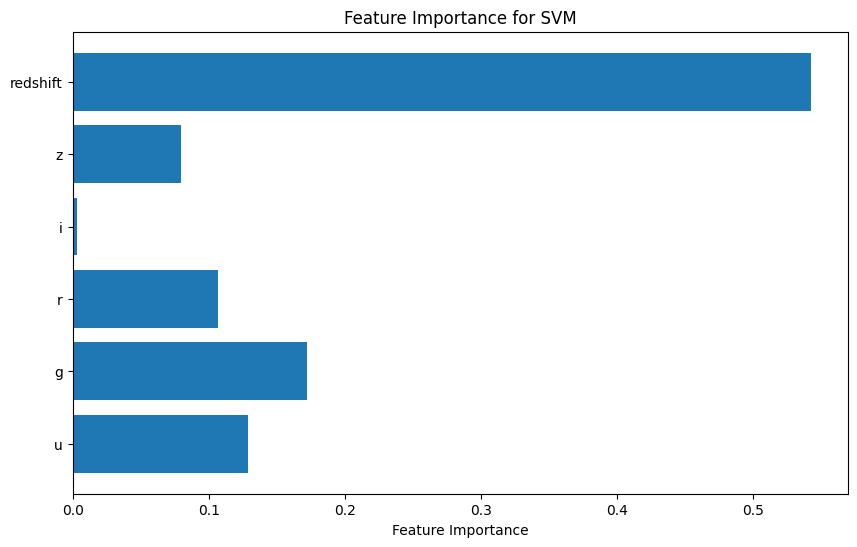

In [65]:
print("\n===== Running SVM =====")
model_name = "SVM"
model_func, plot_func = models[model_name]
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train, y_train, x_val, x_test)
print("Train Result:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train, y_train, model, feature_names)
results["Without PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))


===== Running KNN =====
Best model: KNeighborsClassifier(n_neighbors=3, p=1)
Train Result:
Accuracy: 0.9765625

Classification Report:
               precision    recall  f1-score   support

        STAR       0.96      0.99      0.98      2667
      GALAXY       0.99      0.96      0.98      3181
         QSO       0.99      0.96      0.97       552

    accuracy                           0.98      6400
   macro avg       0.98      0.97      0.98      6400
weighted avg       0.98      0.98      0.98      6400


Confusion Matrix
 [[2652   15    0]
 [ 107 3068    6]
 [   2   20  530]]
Validation Result:
Accuracy: 0.961875

Classification Report:
               precision    recall  f1-score   support

        STAR       0.94      0.99      0.96       655
      GALAXY       0.98      0.94      0.96       817
         QSO       0.98      0.92      0.95       128

    accuracy                           0.96      1600
   macro avg       0.97      0.95      0.96      1600
weighted avg       

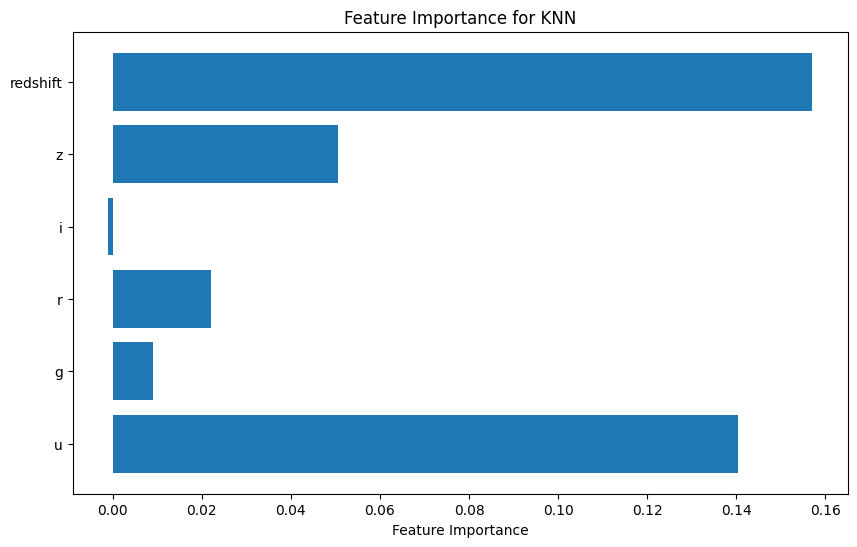

In [66]:
print("\n===== Running KNN =====")
model_name = "KNN"
model_func, plot_func = models[model_name]
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train, y_train, x_val, x_test)
print("Train Result:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train, y_train, model, feature_names)
results["Without PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))


===== Running Logistic Regression =====
Best model: LogisticRegression(C=100, max_iter=10000, penalty='l1', solver='liblinear')
Train Result:
Accuracy: 0.98109375

Classification Report:
               precision    recall  f1-score   support

        STAR       0.99      0.99      0.99      2667
      GALAXY       0.98      0.98      0.98      3181
         QSO       0.96      0.90      0.93       552

    accuracy                           0.98      6400
   macro avg       0.97      0.96      0.97      6400
weighted avg       0.98      0.98      0.98      6400


Confusion Matrix
 [[2653   14    0]
 [  29 3130   22]
 [   1   55  496]]
Validation Result:
Accuracy: 0.979375

Classification Report:
               precision    recall  f1-score   support

        STAR       0.99      0.99      0.99       655
      GALAXY       0.97      0.99      0.98       817
         QSO       0.96      0.88      0.92       128

    accuracy                           0.98      1600
   macro avg       0.

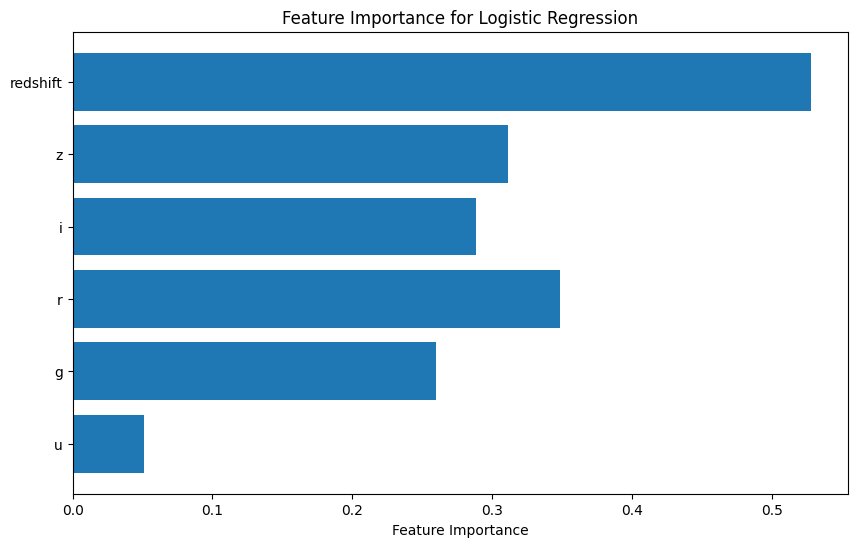

In [67]:
print("\n===== Running Logistic Regression =====")
model_name = "Logistic Regression"
model_func, plot_func = models[model_name]
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train, y_train, x_val, x_test)
print("Train Result:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train, y_train, model, feature_names)
results["Without PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))


===== Running Decision Tree =====
Best model: DecisionTreeClassifier(criterion='entropy', max_depth=15, min_samples_leaf=2)
Train Result:
Accuracy: 0.996875

Classification Report:
               precision    recall  f1-score   support

        STAR       1.00      1.00      1.00      2667
      GALAXY       1.00      1.00      1.00      3181
         QSO       1.00      0.97      0.98       552

    accuracy                           1.00      6400
   macro avg       1.00      0.99      0.99      6400
weighted avg       1.00      1.00      1.00      6400


Confusion Matrix
 [[2667    0    0]
 [   3 3176    2]
 [   1   14  537]]
Validation Result:
Accuracy: 0.988125

Classification Report:
               precision    recall  f1-score   support

        STAR       1.00      1.00      1.00       655
      GALAXY       0.98      1.00      0.99       817
         QSO       0.97      0.88      0.92       128

    accuracy                           0.99      1600
   macro avg       0.98    

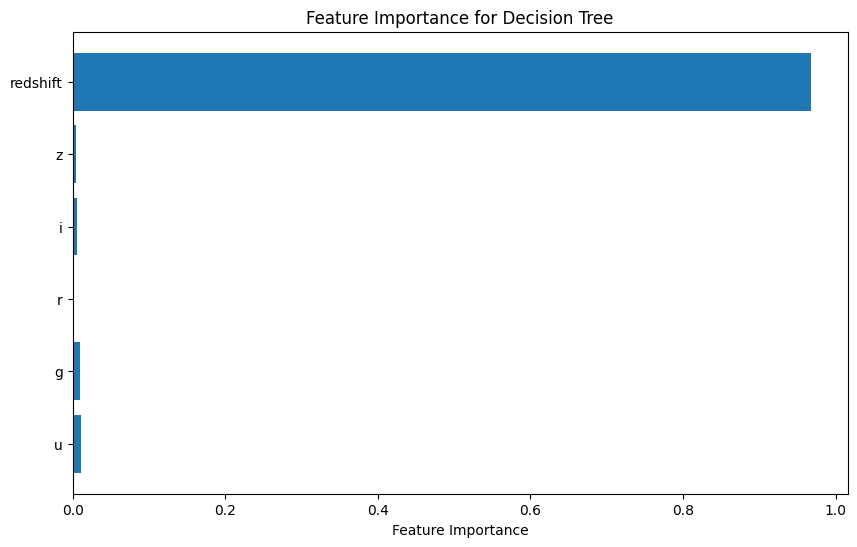

In [68]:
print("\n===== Running Decision Tree =====")
model_name = "Decision Tree"
model_func, plot_func = models[model_name]
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train, y_train, x_val, x_test)
print("Train Result:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train, y_train, model, feature_names)
results["Without PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))


===== Running Random Forest =====
Best model: RandomForestClassifier(max_depth=14, min_samples_split=20, n_estimators=200,
                       n_jobs=-1, random_state=42)
Train Result:
Accuracy: 0.99296875

Classification Report:
               precision    recall  f1-score   support

        STAR       1.00      1.00      1.00      2667
      GALAXY       0.99      0.99      0.99      3181
         QSO       0.98      0.96      0.97       552

    accuracy                           0.99      6400
   macro avg       0.99      0.98      0.99      6400
weighted avg       0.99      0.99      0.99      6400


Confusion Matrix
 [[2667    0    0]
 [  12 3157   12]
 [   1   20  531]]
Validation Result:
Accuracy: 0.990625

Classification Report:
               precision    recall  f1-score   support

        STAR       1.00      1.00      1.00       655
      GALAXY       0.99      0.99      0.99       817
         QSO       0.98      0.92      0.95       128

    accuracy                 

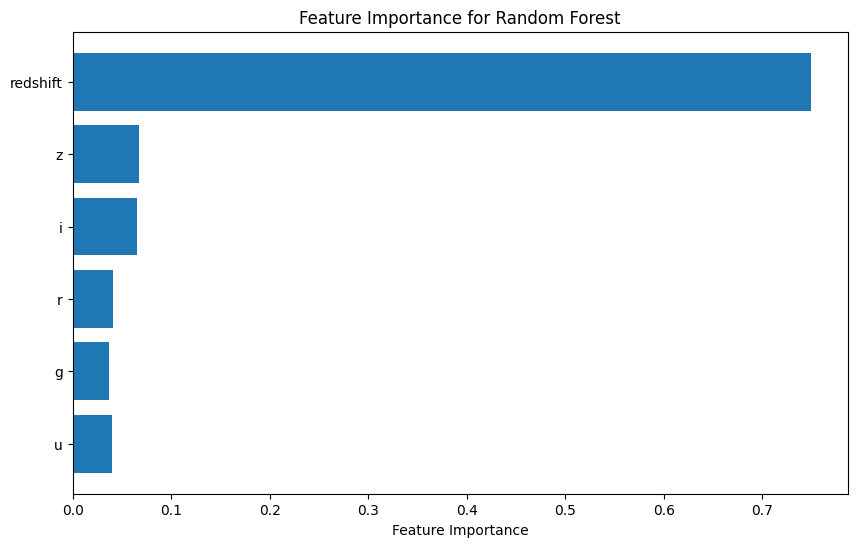

In [69]:
print("\n===== Running Random Forest =====")
model_name = "Random Forest"
model_func, plot_func = models[model_name]
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train, y_train, x_val, x_test)
print("Train Result:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train, y_train, model, feature_names)
results["Without PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))

In [70]:
x_train_pca, x_val_pca, x_test_pca = apply_pca(x_train, x_val, x_test, dim=3) # Reduce to 3 dimenation
feature_names = ['vec1', 'vec2', 'vec3']

Explained Variance Ratio: [0.76665715 0.1472028  0.08066106]
Final Variance Ratio: 0.9945210118154967



===== Running SVM With PCA =====

===== Running SVM With PCA =====
Best model: SVC(C=10, kernel='linear', random_state=42)
Train Result With PCA:
Accuracy: 0.981875

Classification Report:
               precision    recall  f1-score   support

        STAR       0.98      1.00      0.99      2667
      GALAXY       0.98      0.98      0.98      3181
         QSO       0.98      0.92      0.95       552

    accuracy                           0.98      6400
   macro avg       0.98      0.97      0.97      6400
weighted avg       0.98      0.98      0.98      6400


Confusion Matrix
 [[2657   10    0]
 [  50 3118   13]
 [   1   42  509]]
Validation Result With PCA:
Accuracy: 0.985625

Classification Report:
               precision    recall  f1-score   support

        STAR       0.99      1.00      0.99       655
      GALAXY       0.99      0.99      0.99       817
         QSO       0.97      0.91      0.94       128

    accuracy                           0.99      1600
   macro a

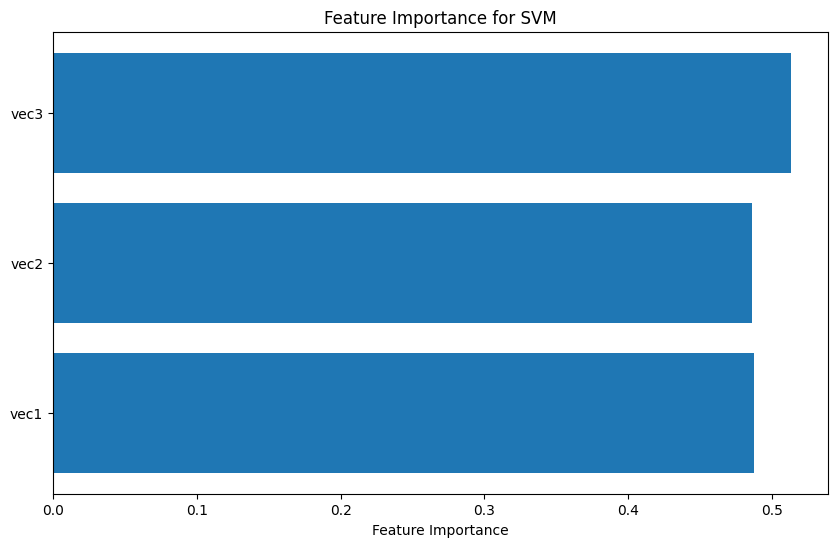

In [71]:
print("\n===== Running SVM With PCA =====")
model_name = "SVM"
model_func, plot_func = models[model_name]
print(f"\n===== Running {model_name} With PCA =====")
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train_pca, y_train, x_val_pca, x_test_pca)
print("Train Result With PCA:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result With PCA:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result With PCA:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train_pca, y_train, model, feature_names)
results["With PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))


===== Running KNN With PCA =====

===== Running KNN With PCA =====
Best model: KNeighborsClassifier(n_neighbors=3)
Train Result With PCA:
Accuracy: 0.9703125

Classification Report:
               precision    recall  f1-score   support

        STAR       0.95      0.99      0.97      2667
      GALAXY       0.98      0.96      0.97      3181
         QSO       0.98      0.95      0.97       552

    accuracy                           0.97      6400
   macro avg       0.97      0.97      0.97      6400
weighted avg       0.97      0.97      0.97      6400


Confusion Matrix
 [[2643   24    0]
 [ 129 3043    9]
 [   3   25  524]]
Validation Result With PCA:
Accuracy: 0.954375

Classification Report:
               precision    recall  f1-score   support

        STAR       0.92      0.99      0.96       655
      GALAXY       0.98      0.93      0.95       817
         QSO       0.98      0.92      0.95       128

    accuracy                           0.95      1600
   macro avg     

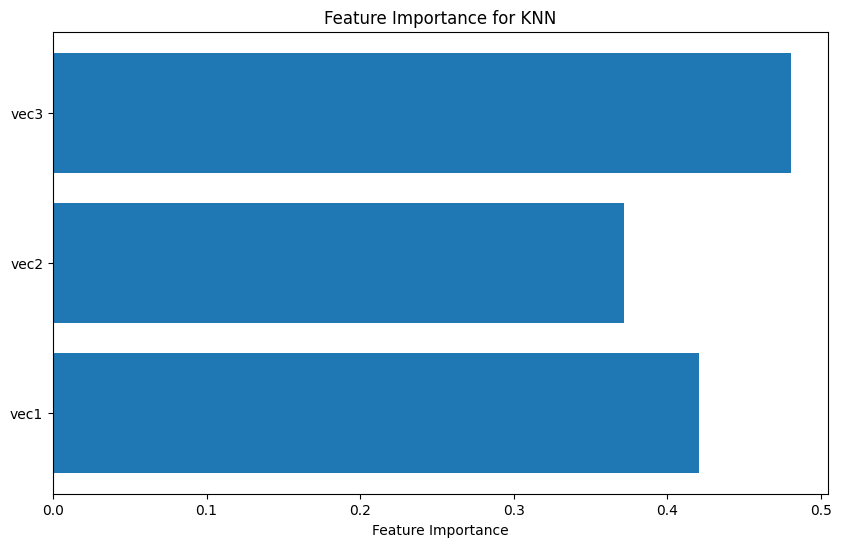

In [72]:
print("\n===== Running KNN With PCA =====")
model_name = "KNN"
model_func, plot_func = models[model_name]
print(f"\n===== Running {model_name} With PCA =====")
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train_pca, y_train, x_val_pca, x_test_pca)
print("Train Result With PCA:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result With PCA:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result With PCA:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train_pca, y_train, model, feature_names)
results["With PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))



===== Running Logistic Regression With PCA =====

===== Running Logistic Regression With PCA =====
Best model: LogisticRegression(C=100, max_iter=10000, penalty='l1', solver='liblinear')
Train Result With PCA:
Accuracy: 0.98109375

Classification Report:
               precision    recall  f1-score   support

        STAR       0.98      1.00      0.99      2667
      GALAXY       0.99      0.98      0.98      3181
         QSO       0.97      0.94      0.95       552

    accuracy                           0.98      6400
   macro avg       0.98      0.97      0.97      6400
weighted avg       0.98      0.98      0.98      6400


Confusion Matrix
 [[2656   10    1]
 [  60 3104   17]
 [   1   32  519]]
Validation Result With PCA:
Accuracy: 0.981875

Classification Report:
               precision    recall  f1-score   support

        STAR       0.98      1.00      0.99       655
      GALAXY       0.99      0.98      0.98       817
         QSO       0.94      0.92      0.93       128

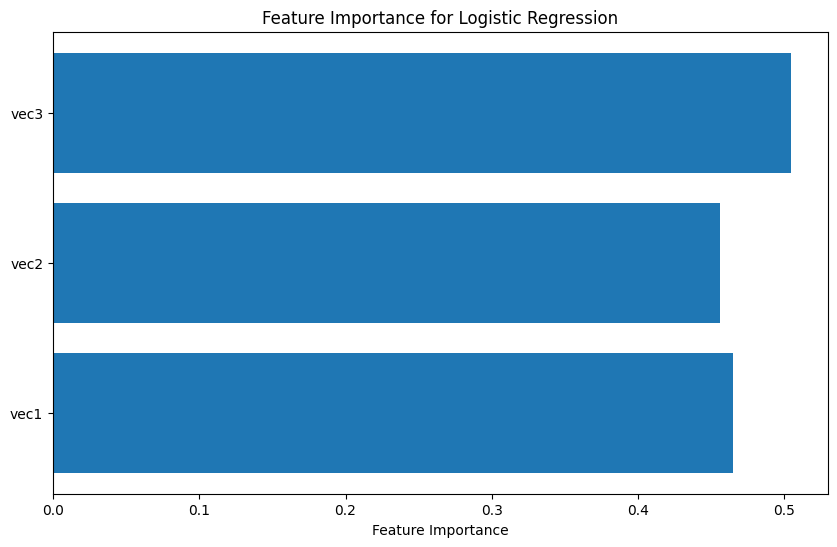

In [73]:
print("\n===== Running Logistic Regression With PCA =====")
model_name = "Logistic Regression"
model_func, plot_func = models[model_name]
print(f"\n===== Running {model_name} With PCA =====")
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train_pca, y_train, x_val_pca, x_test_pca)
print("Train Result With PCA:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result With PCA:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result With PCA:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train_pca, y_train, model, feature_names)
results["With PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))



===== Running Decision Tree With PCA =====

===== Running Decision Tree With PCA =====


/usr/local/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [np.str_('entropy'), np.int64(21), np.int64(2), np.int64(2)] before, using random point ['gini', np.int64(9), np.int64(19), np.int64(16)]
  warnings.warn(


Best model: DecisionTreeClassifier(criterion='entropy', max_depth=18, min_samples_leaf=2)
Train Result With PCA:
Accuracy: 0.98515625

Classification Report:
               precision    recall  f1-score   support

        STAR       0.98      0.99      0.99      2667
      GALAXY       0.99      0.98      0.99      3181
         QSO       1.00      0.97      0.98       552

    accuracy                           0.99      6400
   macro avg       0.99      0.98      0.98      6400
weighted avg       0.99      0.99      0.99      6400


Confusion Matrix
 [[2652   14    1]
 [  60 3120    1]
 [   1   18  533]]
Validation Result With PCA:
Accuracy: 0.920625

Classification Report:
               precision    recall  f1-score   support

        STAR       0.89      0.94      0.92       655
      GALAXY       0.94      0.91      0.92       817
         QSO       0.96      0.91      0.94       128

    accuracy                           0.92      1600
   macro avg       0.93      0.92      0.9

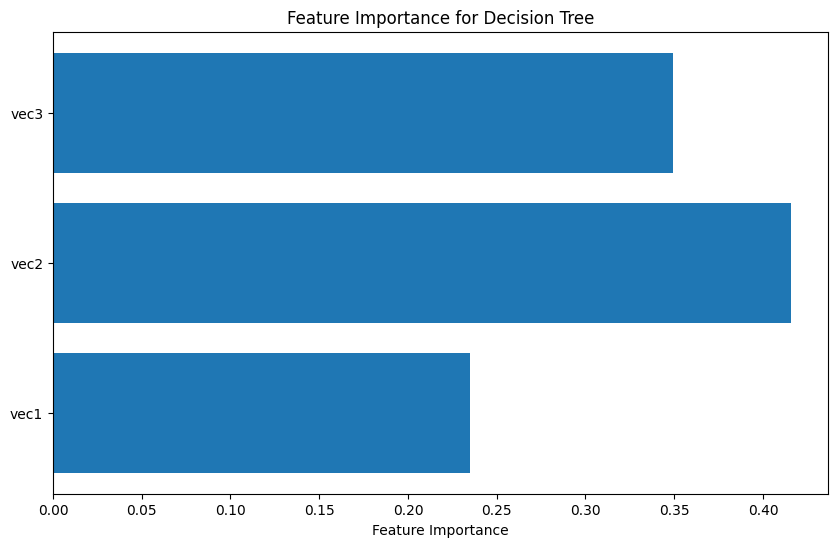

In [74]:
print("\n===== Running Decision Tree With PCA =====")
model_name = "Decision Tree"
model_func, plot_func = models[model_name]
print(f"\n===== Running {model_name} With PCA =====")
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train_pca, y_train, x_val_pca, x_test_pca)
print("Train Result With PCA:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result With PCA:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result With PCA:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train_pca, y_train, model, feature_names)
results["With PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))


===== Running Random Forest With PCA =====

===== Running Random Forest With PCA =====
Best model: RandomForestClassifier(max_depth=20, n_estimators=200, n_jobs=-1,
                       random_state=42)
Train Result With PCA:
Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

        STAR       1.00      1.00      1.00      2667
      GALAXY       1.00      1.00      1.00      3181
         QSO       1.00      1.00      1.00       552

    accuracy                           1.00      6400
   macro avg       1.00      1.00      1.00      6400
weighted avg       1.00      1.00      1.00      6400


Confusion Matrix
 [[2667    0    0]
 [   0 3181    0]
 [   0    0  552]]
Validation Result With PCA:
Accuracy: 0.9325

Classification Report:
               precision    recall  f1-score   support

        STAR       0.91      0.95      0.93       655
      GALAXY       0.95      0.92      0.93       817
         QSO       0.97      0.91      0.94 

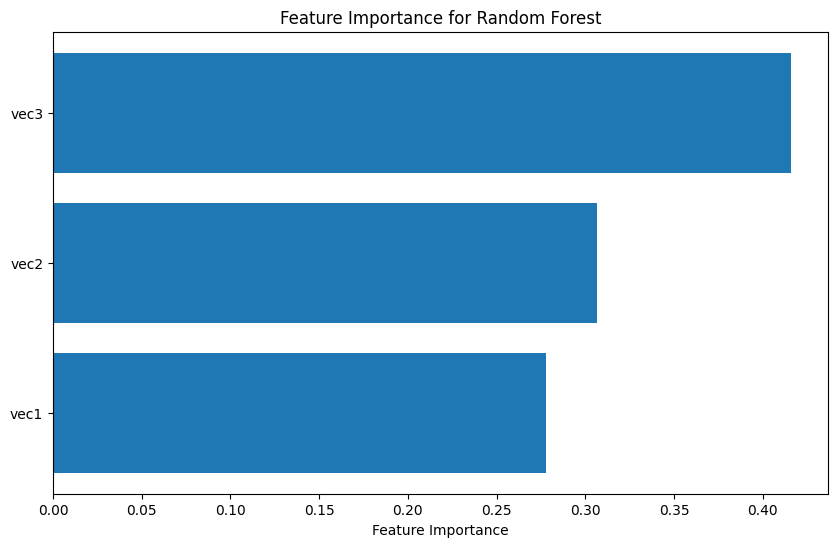

In [75]:
print("\n===== Running Random Forest With PCA =====")
model_name = "Random Forest"
model_func, plot_func = models[model_name]
print(f"\n===== Running {model_name} With PCA =====")
model, y_pred_train, y_pred_val, y_pred_test = model_func(x_train_pca, y_train, x_val_pca, x_test_pca)
print("Train Result With PCA:")
evaluate_model(y_train, y_pred_train, classes)
print("Validation Result With PCA:")
evaluate_model(y_val, y_pred_val, classes)
print("Test Result With PCA:")
evaluate_model(y_test, y_pred_test, classes)
plot_func(x_train_pca, y_train, model, feature_names)
results["With PCA"][model_name] = (accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test))

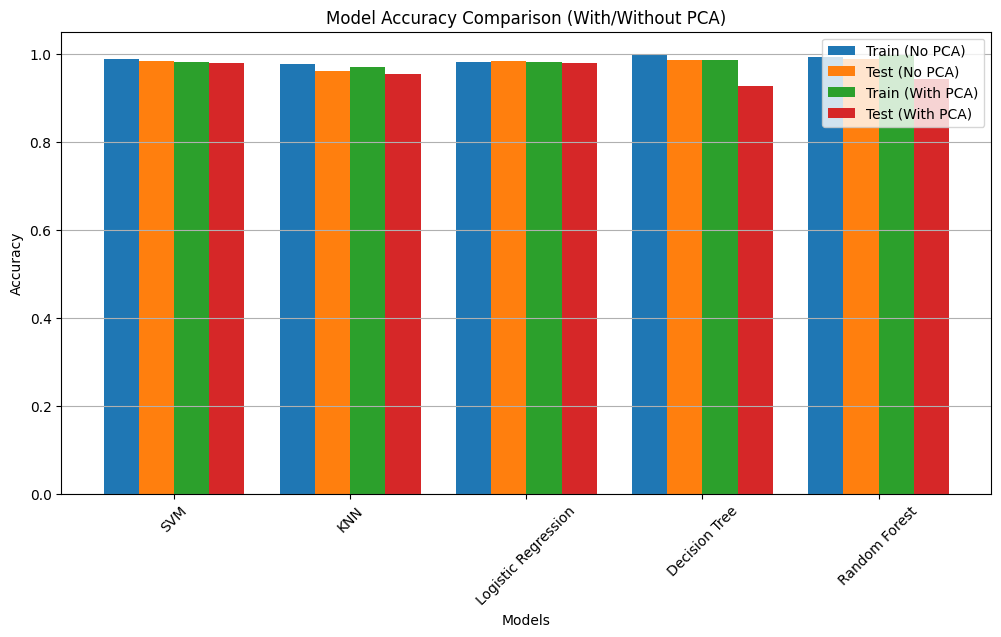

In [76]:
plot_model_comparison(results, models)